In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

CSV_PATH = '../csv'
IMAGE_PATH = './images'

In [14]:
INTERESTED = ['bos', 'caae', 'caca', 'can', 'capi', 'cer', 'dam', 'emp', 'equ', 'fel', 'fsi', 'gen', 'her', 'lep', 'lut', 'lyn', 'mafo', 'mel', 'mus', 'ory', 'ovar', 'ovor', 'rara', 'sus', 'vul']
PARKNAME = {'snieves': "Sierra de las Nieves", 'donana': "Doñana"}
COLORS = {'clean': '#A0C878',
          'discarded': '#CD5656',
          'all': "#8D32EB",
          'snieves': "#888888",
          'donana': "#C2A031", }

In [15]:
RAW = pd.read_csv(f'{CSV_PATH}/raw.csv')
RAW = RAW[RAW['species'].isin(INTERESTED)]
FULL = pd.read_csv(f'{CSV_PATH}/full-interested.csv')
CLEAN = pd.read_csv(f'{CSV_PATH}/clean.csv')
SPLITS = {
    "train": pd.read_csv(f'{CSV_PATH}/train.csv'),
    "val": pd.read_csv(f'{CSV_PATH}/val.csv'),
    "test": pd.read_csv(f'{CSV_PATH}/test.csv'),
}

species_counts = pd.DataFrame({
    'full': FULL['species'].value_counts(),
    'clean': CLEAN['species'].value_counts()
}).fillna(0).astype(int)
species_counts['diff'] = species_counts['full'] - species_counts['clean']

# Functions

In [70]:
def get_pie_chart(pie_data, title, colors):
    plt.figure(figsize=(5, 5))

    wedges, texts = plt.pie(pie_data['Count'], startangle=90, autopct=None, textprops={'fontsize': 14}, colors=colors)

    labels = [f"{row['Category']}\n{round(row['Count']/1000,1)}k ({row['Count'] / pie_data['Count'].sum() * 100:.1f}%)" for _, row in pie_data.iterrows()]
    for i, wedge in enumerate(wedges):
        x, y = wedge.center
        angle = (wedge.theta2 + wedge.theta1) / 2
        x = 0.5 * wedge.r * np.cos(np.radians(angle))
        y = 0.5 * wedge.r * np.sin(np.radians(angle))
        plt.text(x, y, labels[i], ha='center', va='center', fontsize=13.5, color='white')

    plt.tight_layout()
    plt.savefig(f'{IMAGE_PATH}/{title}_comparison.png', bbox_inches='tight', dpi=300)
    plt.show()

In [103]:
def plot_species_distribution(dataframe, title, color):
    species = INTERESTED.copy()
    species.remove('emp')
    species_counts = dataframe['species'].value_counts().reindex(species, fill_value=0)

    plt.figure(figsize=(10, 6))

    colors = sns.light_palette(color, as_cmap=False, n_colors=4)[-2:]*12
    sns.barplot(x=species_counts.index, y=species_counts.values, palette=colors, hue=species_counts.index, legend=False)

    plt.yscale('log')
    plt.ylim(1, species_counts.max() * 5)

    plt.xlabel('Species', fontsize=12)
    plt.ylabel('Count (Log Scale)', fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks(rotation=45, fontsize=12)

    for i, count in enumerate(species_counts.values):
        if count < 1: continue
        plt.text(i, count + count * 0.1, f'{count / 1000:.1f}k' if count >= 1000 else str(count), 
                 ha='center', va='bottom', fontsize=10, rotation=0)

    plt.tight_layout()
    plt.savefig(f'{IMAGE_PATH}/{title}_distribution.png', bbox_inches='tight', dpi=300)
    plt.show()

In [125]:
def get_stacked_bar_chart(data):
    data.plot(kind='bar', stacked=True, width=0.8, color=[COLORS['clean'], COLORS['discarded']], figsize=(7, 4))
    plt.ylabel('Number of images', fontsize=10)
    plt.xlabel('Species', fontsize=10)
    plt.yticks(
        ticks=range(0, int(data.sum(axis=1).max()) + 100000, 100000),
        labels=[f"{x//1000}k" if x > 0 else "0" for x in range(0, int(data.sum(axis=1).max()) + 100000, 100000)],
        fontsize=10
    )
    plt.xticks(rotation=45, fontsize=10)
    plt.legend(['Clean', 'Discarded'], bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'{IMAGE_PATH}/species_clean_diff_bar.png', bbox_inches='tight', dpi=300)
    plt.show()

In [150]:
def plot_species_distribution_and_parks(dataframe, title):
    species_park_counts = dataframe.groupby(['species', 'park']).size().unstack(fill_value=0).reindex(INTERESTED, fill_value=0)

    plt.figure(figsize=(10, 6))

    park_colors = [COLORS[park] for park in species_park_counts.columns]
    species_park_counts.plot(
        kind='bar',
        stacked=True,
        color=park_colors,
        width=0.8,
        ax=plt.gca()
    )

    plt.ylim(0, species_park_counts.sum(axis=1).max() * 1.2)

    plt.xlabel('Species', fontsize=12)
    plt.ylabel('Count (Log Scale)', fontsize=12)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    for i, count in enumerate(species_park_counts.sum(axis=1).values):
        if count < 1: continue
        plt.text(i, count + 10, f'{count / 1000:.1f}k' if count >= 1000 else str(count), 
                 ha='center', va='bottom', fontsize=10, rotation=0)

    plt.legend([PARKNAME.get(p, p) for p in species_park_counts.columns], title="Park", fontsize=12, bbox_to_anchor=(0.52, 1))

    plt.tight_layout()
    plt.savefig(f'{IMAGE_PATH}/species_distribution_{title}.png')
    plt.show()

# Raw

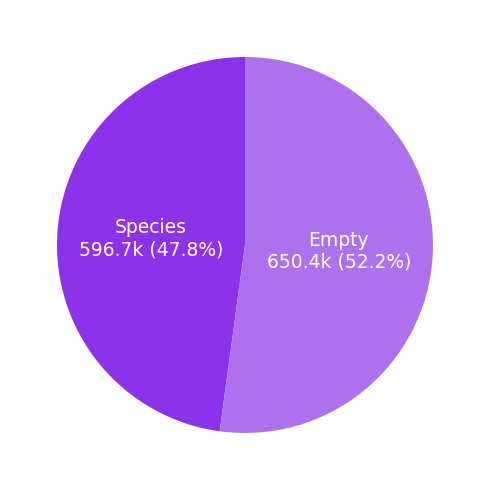

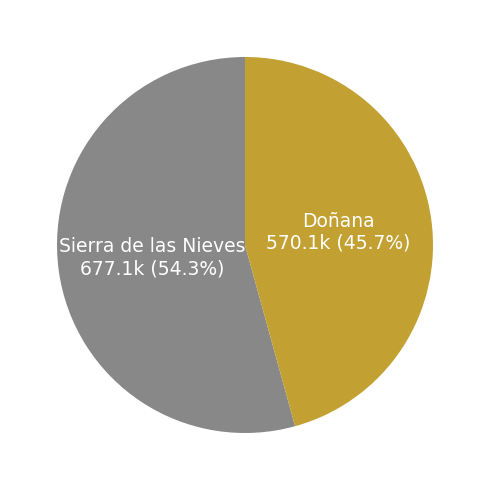

In [151]:
# Pie chart for Species Images vs Empty Images
speciesvempty = pd.DataFrame({
    'Category': ['Species', 'Empty'],
    'Count': [RAW[RAW['species'] != 'emp'].shape[0], RAW[RAW['species'] == 'emp'].shape[0]]
})
colors = sns.light_palette(COLORS['all'], as_cmap=False, n_colors=4)[-2:][::-1]
get_pie_chart(speciesvempty, 'empty_species', colors)

# Pie chart for Park Images
parks = RAW['park'].value_counts().index
parks_data = pd.DataFrame({
    'Category': [PARKNAME.get(park, park) for park in parks],
    'Count': RAW['park'].value_counts().values
})
colors = [f"{COLORS[park]}" for park in parks]
get_pie_chart(parks_data, 'parks', colors)

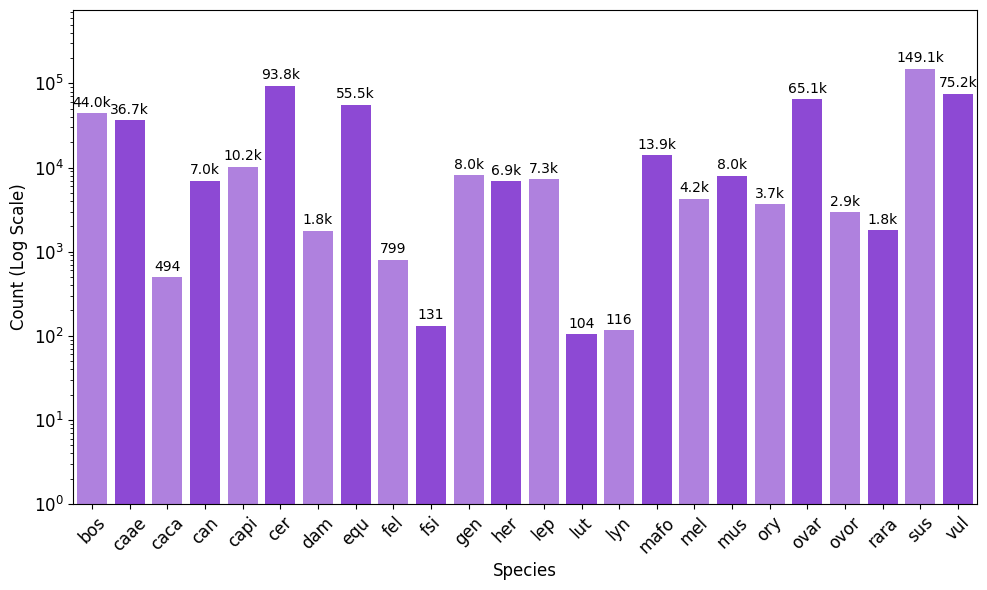

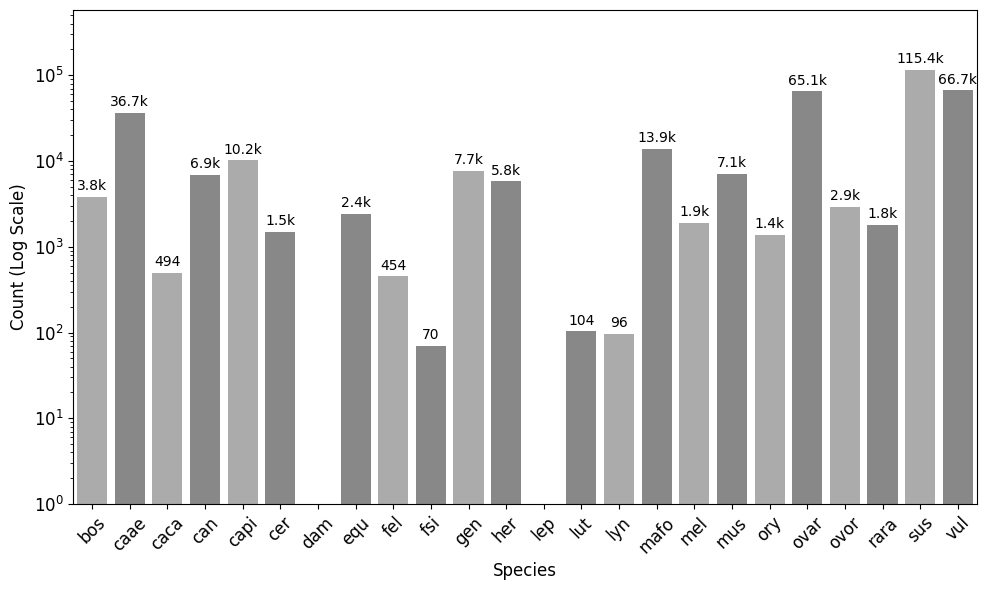

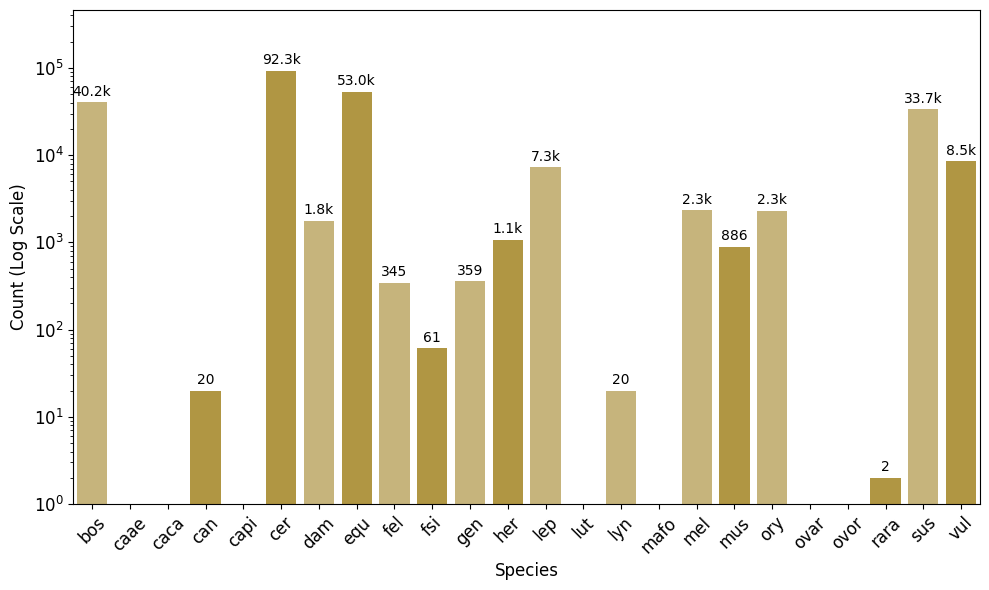

In [152]:
# Plot species distribution
plot_species_distribution(RAW[RAW['species'] != 'emp'], "species", COLORS['all'])

# Plot species distribution for each park
for park in RAW['park'].unique():
    plot_species_distribution(RAW[RAW['park'] == park], park, COLORS[park])

# Processing

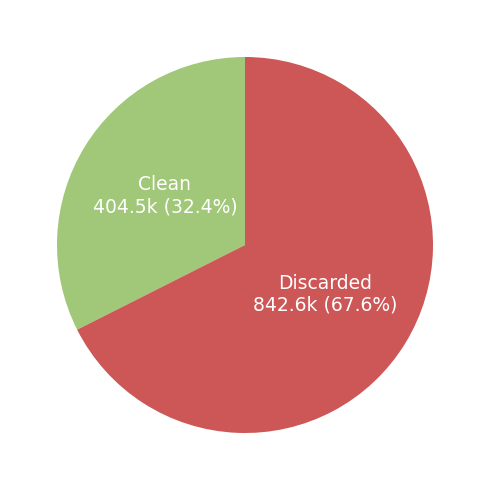

In [153]:
# Pie chart comparing full and diff count
plot_df = pd.DataFrame({
    'Category': ['Clean', 'Discarded'],
    'Count': species_counts[['clean', 'diff']].sum()
})
get_pie_chart(plot_df, 'clean_diff', [COLORS['clean'], COLORS['discarded']])

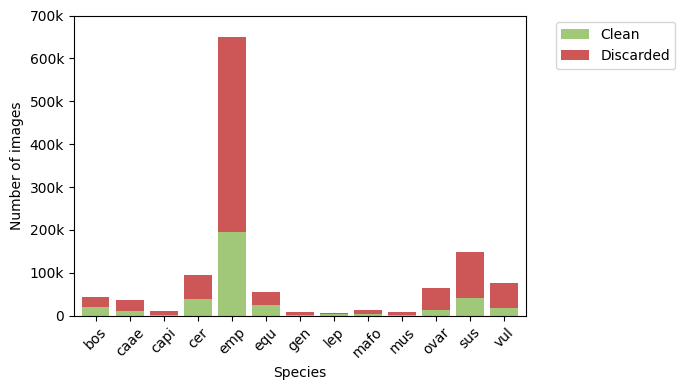

In [154]:
# Plot the difference between FULL and CLEAN
plot_df = species_counts[species_counts['diff'] != 0][['clean', 'diff']]
get_stacked_bar_chart(plot_df)

# Splits

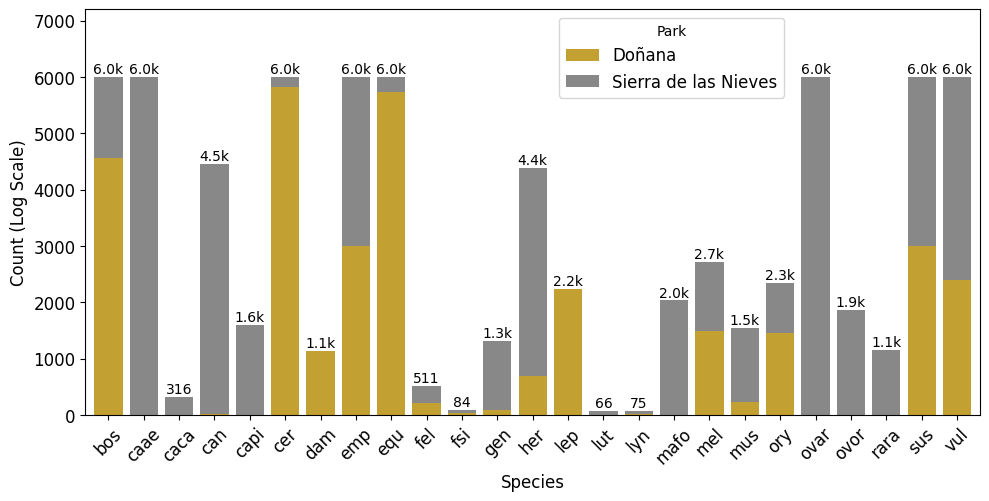

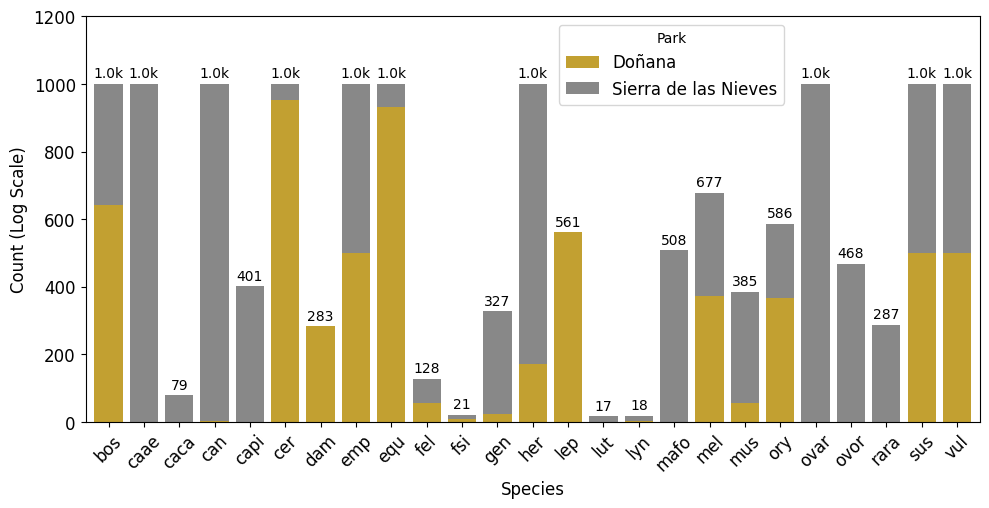

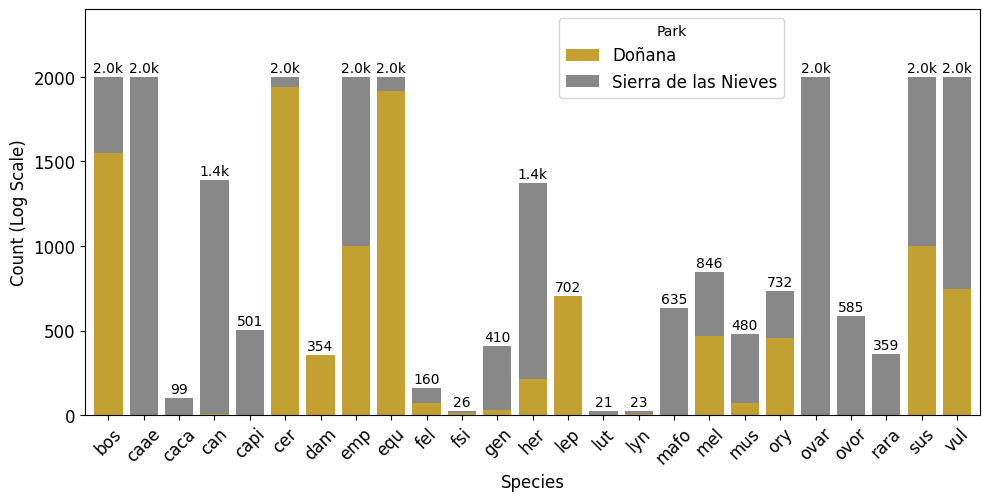

In [155]:
# Plot species distribution for each dataset split
for name, dataframe in SPLITS.items():
    plot_species_distribution_and_parks(dataframe, name)